In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2 
import random
import os
%matplotlib inline


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## explorating Datasets

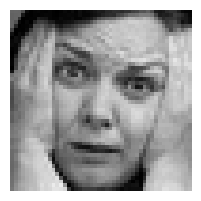

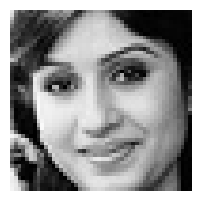

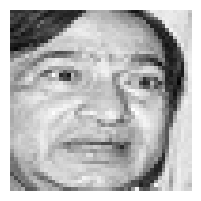

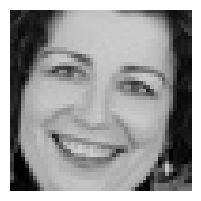

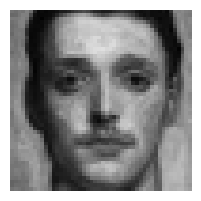

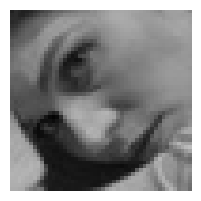

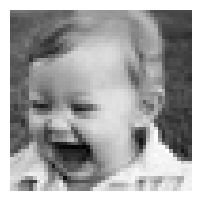

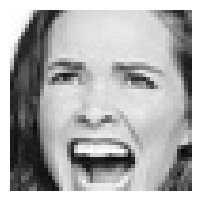

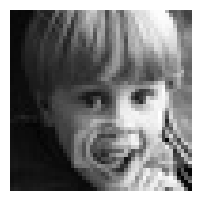

In [2]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(8,8))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

## preparing data for training

In [32]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
                                              target_size = (img_size,img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                              target_size = (img_size,img_size),
                                              color_mode = "grayscale",
                                              batch_size = batch_size,
                                              class_mode = "categorical",
                                              shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## defining  model

In [23]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

    

In [24]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x


In [27]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(inputs,64,(5,5))
    conv_3 = Convolution(inputs,128,(3,3))
    
    flatten = Flatten()(conv_3)
    
    dense_1 = Dense_f(flatten,256)
    
    output = Dense(7,activation = "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [29]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

## initialing the model 

In [38]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

## traning the model

In [40]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.6269 - loss: 1.0313
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 294s 655ms/step - accuracy: 0.6269 - loss: 1.0313 - val_accuracy: 0.4325 - val_loss: 1.4934
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:30 606ms/step - accuracy: 0.6562 - loss: 0.9712
Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.9712 - val_accuracy: 0.2000 - val_loss: 1.6209
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.6752 - loss: 0.9012
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 291s 650ms/step - accuracy: 0.6752 - loss: 0.9013 - val_accuracy: 0.3870 - val_loss: 1.6464
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4:33 613ms/step - accuracy: 0.6094 - loss: 0.9179
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6094 - loss: 0.9179 - val_accuracy: 0.5000 - val_loss: 2.1763


## model Evaluation

In [41]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.4439 - loss: 1.9077


[1.923815369606018, 0.4414878785610199]

## plotting looses

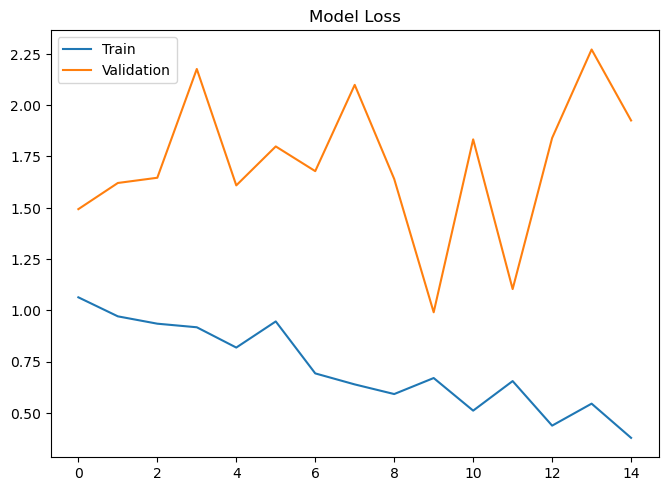

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, right= 0.95, left=0.0, hspace=0.25, wspace=0.35)

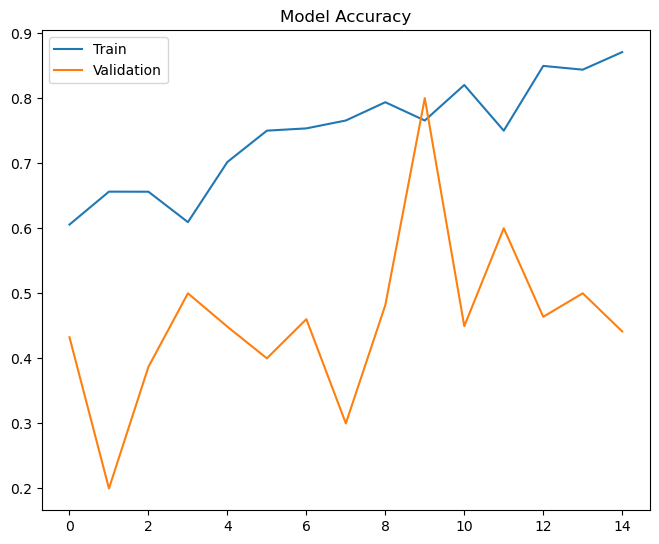

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0, right= 0.95, left=0.0, hspace=0.25, wspace=0.35)

## saving model

In [44]:
model_json = model.to_json()
with open("model_a.json", "w")as json_file:
    json_file.write(model_json)